## MISA (2024-2025)
- Alohan'ny mamerina dia avereno atao Run ny notebook iray manontolo. Ny fanaovana azy dia redémarrena mihitsy ny kernel aloha (jereo menubar, safidio **Kernel$\rightarrow$Restart Kernel and Run All Cells**).

- Izay misy hoe `YOUR CODE HERE` na `YOUR ANSWER HERE` ihany no fenoina. Afaka manampy cells vaovao raha ilaina. Aza adino ny mameno references eo ambany raha ilaina.

## References
* [Python time module](https://docs.python.org/3/library/time.html)
* [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html)
* [matplotlib](https://matplotlib.org/stable/index.html)

---

In [1]:
import cvxpy as cp
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

data = load_diabetes()
X_train, y_train = data.data, data.target

## Linear Program

The minimum amount of nutrients of a healthy diet is presented in the following table:
|  Nutrient | Minimum recommended intake |  
|---|---|
|  Calories | 3 kcal  |  
|  Protein | 70 g  |   
|  Calcium | 0.8 g  |  
|  Iron | 12 mg  | 
|  Vitamin A | 5000 IU  | 
|  Vitamin B1 | 1.8 mg  | 
|  Vitamin B2 | 2.7 mg  | 
|  Niacin | 18 mg  | 
|  Vitamin C | 75 mg  | 

Each row of the table in the *diet.csv* file presents the amount of nutrients present in one dollar worth of food. How many dollars should one spend on each food so that the total cost is minimum ?

In [2]:
df = pd.read_csv("diet.csv", index_col=0)

# Définir les variables d'optimisation : montant dépensé pour chaque aliment (en dollars)
x = cp.Variable(len(df), nonneg=True)  # Montants dépensés pour chaque aliment

# Apports minimaux recommandés
min_nutrients = {
    "Calories (1000)": 3,  # Calories minimales
    "Protein (g)": 70,  # Protéines minimales
    "Calcium (g)": 0.8,  # Calcium minimal
    "Iron (mg)": 12,  # Fer minimal
    "Vitamin A (1000 IU)": 5000,  # Vitamine A minimale
    "Thiamine (mg)": 1.8,  # Thiamine minimale
    "Riboflavin (mg)": 2.7,  # Riboflavine minimale
    "Niacin (mg)": 18,  # Niacine minimale
    "Ascorbic Acid (mg)": 75  # Acide ascorbique minimal
}

# Fonction objectif : Minimiser le coût total
# Le coût est simplement la somme des montants dépensés (chaque aliment a un coût de 1$ par dollar dépensé)
objective = cp.Minimize(cp.sum(x))

# Contraintes nutritionnelles : chaque nutriment doit respecter l'apport minimum
constraints = []
for nutrient, min_value in min_nutrients.items():
    if nutrient in df.columns:
        # La contrainte est que la somme des nutriments (quantité dans chaque aliment * dollars dépensés) soit supérieure au minimum requis
        constraints.append(df[nutrient].values @ x >= min_value)
    else:
        print(f"Attention : La colonne '{nutrient}' n'est pas présente dans les données.")

# Formuler et résoudre le problème
problem = cp.Problem(objective, constraints)
problem.solve()

# Extraire la solution optimale
opt_solution = {df.index[i]: x.value[i] for i in range(len(df)) if x.value[i] > 0}

# Afficher la solution optimale
print("Montant optimal dépensé pour chaque aliment :")
for food, amount in opt_solution.items():
    print(f"{food}: ${amount}")


Montant optimal dépensé pour chaque aliment :
Wheat Flour (Enriched): $1.524284818757732e-10
Macaroni: $6.50584971104175e-11
Wheat Cereal (Enriched): $3.9480305411636124e-10
Corn Flakes: $4.1461321303699845e-11
Corn Meal: $9.106471323989057e-11
Hominy Grits: $7.715289452706178e-11
Rice: $6.738939031983216e-11
Rolled Oats: $1.1229978356854166e-10
White Bread (Enriched): $7.856544792666362e-11
Whole Wheat Bread: $7.927436823801561e-11
Rye Bread: $6.884275647165782e-11
Pound Cake: $1.070581313624833e-12
Soda Crackers: $4.6743408552047643e-11
Milk: $1.8505211174502584e-10
Evaporated Milk (can): $2.9072280807099125e-10
Eggs: $4.188857333519079e-11
Cheese (Cheddar): $0.048780487064150356
Peanut Butter: $8.44474873575268e-11
Lard: $2.741332611264827e-11
Sirloin Steak: $1.626086524140374e-11
Round Steak: $3.147544239871472e-11
Rib Roast: $2.740978170570047e-11
Chuck Roast: $5.073813647138834e-11
Plate: $6.053444067090488e-11
Liver (Beef): $9.238450118248744e-11
Leg of Lamb: $3.824083905487237e

## Non-negative Linear Regression

In [3]:
class NonNegativeLinearRegression:
    def __init__(self, fit_intercept=True):
        # Initialisation des coefficients
        self.w = None
        self.fit_intercept = fit_intercept
        
    def fit(self, X, y):
        # Si fit_intercept est True, ajoutons une colonne de 1 pour le biais
        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])
        
        # Nombre de caractéristiques
        n_features = X.shape[1]
        
        # Définition des variables de décision (coefficients)
        w = cp.Variable(n_features, nonneg=True)  # Coefficients non négatifs
        
        # Fonction de coût : somme des erreurs quadratiques
        residuals = X @ w - y  # Résidus de la prédiction
        cost = cp.sum_squares(residuals)  # Erreur quadratique
        
        # Résoudre le problème d'optimisation
        problem = cp.Problem(cp.Minimize(cost))
        problem.solve()

        # Extraire les coefficients
        self.w = w.value
        
    def predict(self, X):
        # Si fit_intercept est True, ajoutons une colonne de 1 pour le biais
        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])
        
        # Prédiction : X @ w (produit matriciel)
        return X @ self.w


In [4]:
nnlr = NonNegativeLinearRegression(fit_intercept=True)
nnlr.fit(X_train,y_train)
y_pred = nnlr.predict(X_train)
mse = mean_squared_error(y_pred, y_train)

sk_model = LinearRegression(fit_intercept=True, positive=True)
sk_model.fit(X_train, y_train)
sk_pred = sk_model.predict(X_train)
sk_mse = mean_squared_error(sk_pred, y_train)

print("MSE scikit-learn:", sk_mse)
print("MSE gradient descent model :", mse)
assert mse - sk_mse < 200

MSE scikit-learn: 3074.1786797315144
MSE gradient descent model : 3074.1786797315144


## Compare the runtime of the different Linear regression training methods using a large dataset. You might want to plot the results and perform a statistical test. 

In [5]:
import numpy as np
import scipy
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.linear_model import LinearRegression as LR
import time
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

### INVERSE

In [6]:
def fit_inverse(X, y):
    """Direct method using the inverse (without bias term)"""
    
    # Calculer la matrice X^T X
    XtX = np.dot(X.T,X)

    # Vérifier si X^T X est inversible (si son déterminant est non nul)
    if np.linalg.det(XtX) == 0:
        raise ValueError("La matrice X^T X est singulière, donc l'inverse ne peut pas être calculé.")
    
    # Calculer l'inverse de X^T X
    XtX_inv = np.linalg.inv(XtX)

    # Calculer les coefficients beta
    Xt_y = np.dot(X.T, y)

    beta = np.dot(XtX_inv, Xt_y)
    
    return beta

### CHOLESKY

In [7]:
def fit_cholesky(X, y):
    """ Cholesky approach """
    # Calculer X^T X
    XtX = np.dot(X.T, X)

    # Vérifier que la matrice XtX est définie positive avant de faire la décomposition de Cholesky
    if np.all(np.linalg.eigvals(XtX) > 0):
        # Calculer la décomposition de Cholesky de XtX
        L = np.linalg.cholesky(XtX)

        # Résoudre Lz = X^T y pour z (première étape)
        z = np.linalg.solve(L, np.dot(X.T, y))

        # Résoudre L^T beta = z pour beta (deuxième étape)
        beta = np.linalg.solve(L.T, z)
        return beta
    else:
        raise ValueError("La matrice X^T X n'est pas définie positive, décomposition de Cholesky échouée.")


### QR

In [8]:
def fit_qr(X, y):
    """ QR approach """
    # Décomposition QR de X
    Q, R = np.linalg.qr(X)
    
    # Résoudre pour beta en utilisant R et Q^T y
    Qt_y = np.dot(Q.T, y)  # Calculer Q^T y
    beta = np.linalg.solve(R, Qt_y)  # Résoudre R beta = Q^T y
    
    return beta

### SVD

In [9]:
def fit_svd(X, y):
    """ SVD approach for solving X^T X beta = X^T y """
    
    # Calculer la décomposition SVD de X
    U, Sigma, Vt = np.linalg.svd(X, full_matrices=False)
    
    
    # Inverser Sigma (les valeurs singulières de X)
    Sigma_inv = np.diag(1.0 / Sigma)  # Inverser les valeurs singulières
    
    # Calculer beta = V * Sigma_inv * U.T * y
    # On peut directement calculer la multiplication dans l'ordre suivant :
    beta = np.dot(Vt.T, np.dot(Sigma_inv, np.dot(U.T, y)))
    
    return beta

### PSEUDO-INVERSE

In [10]:
import numpy as np

def fit_pseudo_inverse(X, y):
    """
    Calcule les coefficients de régression linéaire à partir du pseudoinverse de X.T X.
    
    Parameters:
    X : array-like, shape (n_samples, n_features)
        Matrice des caractéristiques.
    y : array-like, shape (n_samples,)
        Valeurs cibles.
    
    Returns:
    beta : array-like, shape (n_features,)
        Coefficients de régression linéaire.
    """
    # Calculer X.T X
    XtX = np.dot(X.T, X)
    
    # Calculer le pseudoinverse de XtX
    XtX_pseudo_inv = np.linalg.pinv(XtX)
    
    # Calculer les coefficients beta
    Xt_y = np.dot(X.T, y)
    beta = np.dot(XtX_pseudo_inv, Xt_y)
    
    return beta


Temps moyen d'exécution pour fit_inverse: 0.000518 secondes
Temps moyen d'exécution pour fit_cholesky: 0.000139 secondes
Temps moyen d'exécution pour fit_qr: 0.000152 secondes
Temps moyen d'exécution pour fit_svd: 0.000097 secondes
Temps moyen d'exécution pour fit_pseudo_inverse: 0.000078 secondes

La méthode la plus rapide est fit_pseudo_inverse avec un temps moyen de 0.000078 secondes.


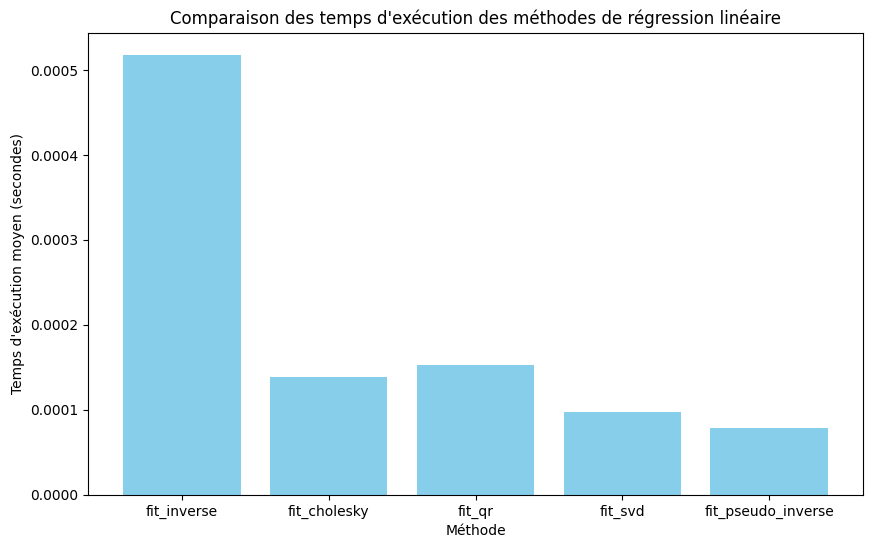

In [11]:
def compare_methods(X, y, n_repeats=10):
    # Initialisation d'une liste pour stocker les temps d'exécution
    times = {method_name: [] for method_name in ['fit_inverse', 'fit_cholesky', 'fit_qr', 'fit_svd', 'fit_pseudo_inverse']}
    
    # Liste des méthodes à tester
    methods = [fit_inverse, fit_cholesky, fit_qr, fit_svd, fit_pseudo_inverse]
    method_names = ['fit_inverse', 'fit_cholesky', 'fit_qr', 'fit_svd', 'fit_pseudo_inverse']

    # Mesurer le temps d'exécution de chaque méthode n_repeats fois
    for i, method in enumerate(methods):
        for _ in range(n_repeats):
            start_time = time.time()
            method(X, y)
            elapsed_time = time.time() - start_time
            times[method_names[i]].append(elapsed_time)

    # Calculer les temps d'exécution moyens
    avg_times = [np.mean(times[method]) for method in method_names]

    # Afficher les temps moyens dans la console
    for method, avg_time in zip(method_names, avg_times):
        print(f"Temps moyen d'exécution pour {method}: {avg_time:.6f} secondes")

    # Comparer les temps moyens
    fastest_method_index = np.argmin(avg_times)
    print(f"\nLa méthode la plus rapide est {method_names[fastest_method_index]} avec un temps moyen de {avg_times[fastest_method_index]:.6f} secondes.")

    # Tracer les temps d'exécution
    plt.figure(figsize=(10, 6))
    plt.bar(method_names, avg_times, color='skyblue')
    plt.xlabel('Méthode')
    plt.ylabel('Temps d\'exécution moyen (secondes)')
    plt.title('Comparaison des temps d\'exécution des méthodes de régression linéaire')
    plt.show()

# Comparer les méthodes
compare_methods(X_train, y_train)